##In this Task we will perform Image Editing on Face Images
##Dataset --> CelebA Dataset

###Importing Libraries

In [1]:
import numpy as np 
from glob import glob
import random
from PIL import Image 
import os
import matplotlib.pyplot as plt 

In [2]:
from keras.preprocessing.image import save_img
from keras.preprocessing.image import array_to_img

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
print(tf.__version__)

2.4.1


##Class Definition of DCGAN as presented in paper by Radford et. al. 

####The Model Architecture of Generator of DCGAN (Deep Convolutional GAN) as discussed in the Original Paper
####But we are using a slightly different Architecture from the original one

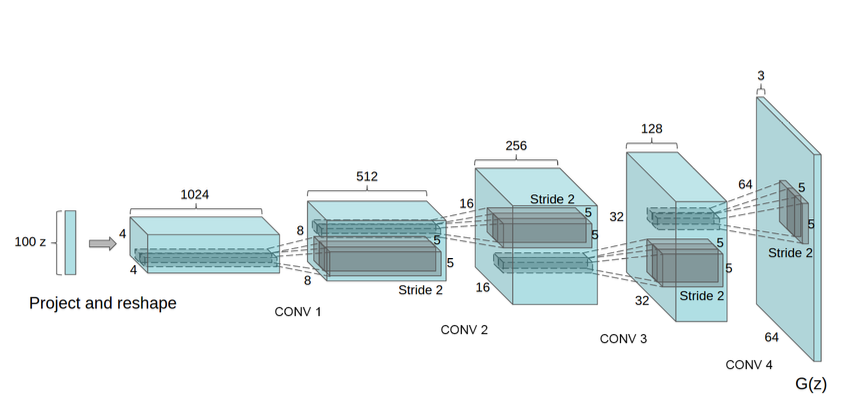

####The model Architecture of Discriminator of DCGAN as discussed in original paper is follwing
####But we are using a slightly different Architecture as compared to original paper

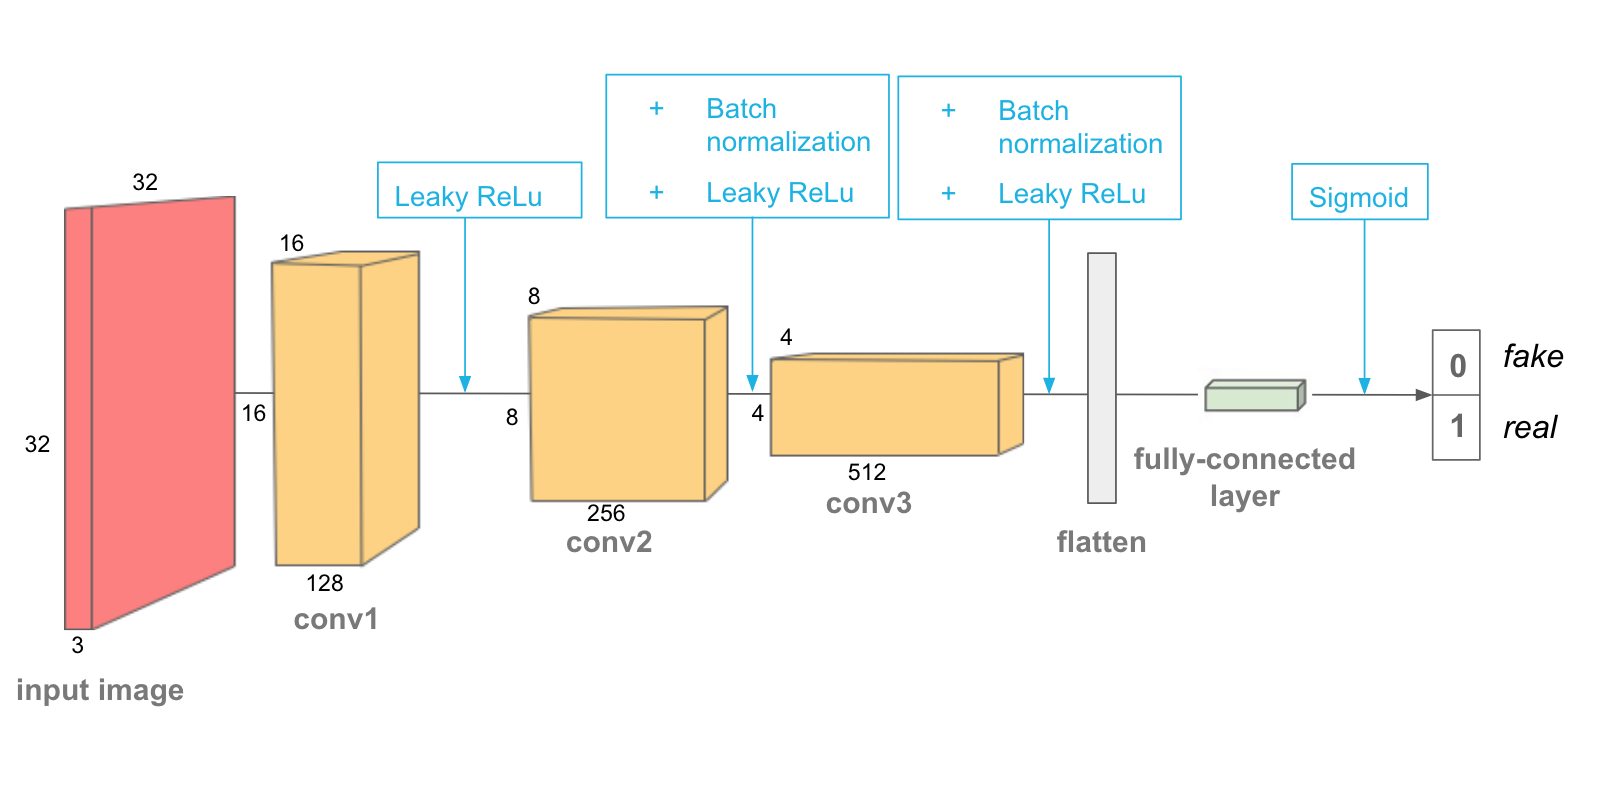

####Working of DCGAN

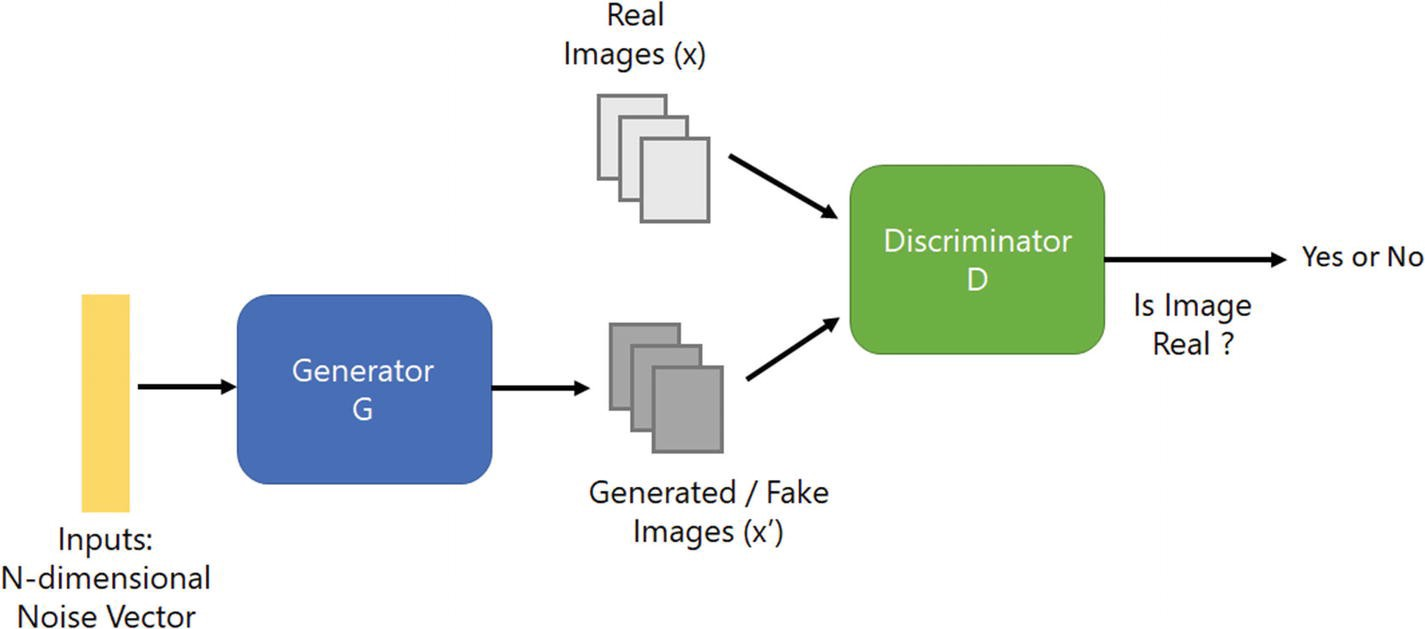

In [5]:
class DCGAN:
    
    def __init__(self, input_shape, z_dim, lr_rate, beta1=0.5, alpha=0.2):

        # Initialising the variables
        self.lr_rate = tf.Variable(lr_rate, trainable=False)
        self.input_shape = input_shape
        self.z_dim = z_dim

        # Calling the model_io function
        self.input_real, self.input_z = self.model_io(self.input_shape,self.z_dim)
        
        # Calling the model_loss fucntion
        self.disc_loss, self.gen_loss, self.output_gen = self.model_loss(self.input_real, self.input_z, self.input_shape[2])  

        # Calling the model_opti function     
        self.disc_opt, self.gen_opt = self.model_opti(self.disc_loss, self.gen_loss, self.lr_rate, beta1)

     
   
    """    
    Function to model placeholders for input of both generator and discriminator
    """     
    def model_io(self, input_shape, z_dim):

        inputs_real = tf.placeholder(tf.float32, shape=(None, input_shape[0], input_shape[1], input_shape[2]), name="input_real")
        inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")

        return inputs_real,inputs_z   



    """
    Generator Architecture
    """
    def generator(self, z, out_channel_dim, is_train=True):

        # Intialising the weights with mean = 0 and stddev = 0.02
        w_init = tf.random_normal_initializer(mean=0.0, stddev = 0.02)

        with tf.variable_scope('generator', reuse= False if is_train==True else True):
            
            x1 = tf.reshape(z,(-1,1,1,100))
            
            # Adding the first Deconv layer 
            # 512 filters of 4x4 (kernel = 4) with stride = 1
            deconv1 = tf.layers.conv2d_transpose(x1, 512, 4, 1, padding='VALID', kernel_initializer=w_init)
            # Applying the Spatial Batch Normalisation layer
            bn_norm1 = tf.layers.batch_normalization(deconv1, training=is_train)
            # Applying the ReLu function
            relu1 = tf.nn.relu(bn_norm1)
            
            # Adding the second Deconv layer 
            # 256 filters of 4x4 (kernel = 4) with stride = 2
            deconv2 = tf.layers.conv2d_transpose(relu1, 256, 4, 2, padding='SAME', kernel_initializer=w_init)
            bn_norm2 = tf.layers.batch_normalization(deconv2, training=is_train)
            relu2 = tf.nn.relu(bn_norm2)
            
            # Adding the third Deconv layer 
            # 128 filters of 4x4 (kernel = 4) with stride = 2
            deconv3 = tf.layers.conv2d_transpose(relu2, 128, 4, 2, padding='SAME', kernel_initializer=w_init)
            bn_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
            relu3 = tf.nn.relu(bn_norm3)
            
            # Adding the fourth Deconv layer 
            # 64 filters of 4x4 (kernel = 4) with stride = 2
            deconv4 = tf.layers.conv2d_transpose(relu3, 64, 4, 2, padding='SAME', kernel_initializer=w_init)
            bn_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
            relu4 = tf.nn.relu(bn_norm4)
            
            # Adding the fifth Deconv layer 
            # output dimension filters of 4x4 (kernel = 4) with stride = 2
            deconv5 = tf.layers.conv2d_transpose(relu4, out_channel_dim, 4, 2, padding='SAME', kernel_initializer=w_init)
            
            logits = deconv5
            out = tf.tanh(deconv5, name="generator_out")
            
            return out, logits  

  

    
    """
    Discriminator Architecture

    Architecture is similar as described in the photo above
    """
    def discriminator(self, images, alpha=0.2, reuse = False):

       # Initialising the weights
       w_init = tf.random_normal_initializer(mean=0.0, stddev=0.02)

       with tf.variable_scope('discriminator',reuse=reuse):
           
           # Adding the first Conv layer
           # 64 filters of 4x4 (kernel = 4) with stride = 2
           conv1 = tf.layers.conv2d(images, 64, 4, 2, padding='SAME', kernel_initializer=w_init)
           # Applying LeakyReLu fucntion
           lrelu1 = tf.nn.leaky_relu(conv1, alpha=alpha)
           
           # Adding the second Conv layer
           # 128 filters of 4x4 (kernel = 4) with stride = 2
           conv2 = tf.layers.conv2d(lrelu1, 128, 4, 2, padding='SAME', kernel_initializer=w_init)
           bn_norm1 = tf.layers.batch_normalization(conv2, training=True)
           lrelu2 = tf.nn.leaky_relu(bn_norm1, alpha=alpha)
           
           # Adding the third Conv layer
           # 256 filters of 4x4 (kernel = 4) with stride = 2
           conv3 = tf.layers.conv2d(lrelu2, 256, 4, 2, padding='SAME', kernel_initializer=w_init)
           bn_norm2 = tf.layers.batch_normalization(conv3, training=True)
           lrelu3 = tf.nn.leaky_relu(bn_norm2, alpha=alpha)
           
           # Adding the fourth Conv layer
           # 512 filters of 4x4 (kernel = 4) with stride = 2
           conv4 = tf.layers.conv2d(lrelu3, 512, 4, 2, padding='SAME', kernel_initializer=w_init)
           bn_norm3 = tf.layers.batch_normalization(conv4, training=True)
           lrelu4 = tf.nn.leaky_relu(bn_norm3, alpha=alpha)
           
           # Adding the fifth Conv layer
           # 512 filters of 4x4 (kernel = 4) with stride = 2
           conv5 = tf.layers.conv2d(lrelu4, 512, 4, 2, padding='SAME', kernel_initializer=w_init)
           
           flat = tf.reshape(conv5,(-1,512))
           
           # Adding a Dense Layer 
           logits = tf.layers.dense(flat, 1, kernel_initializer=w_init)
           
           out = tf.sigmoid(logits, name="discriminator_out")
           
           return out, logits


    """
    Function to model the loss for both generator and discriminator. Returns the generated image.
    """       
    def model_loss(self, input_real, input_z, out_channel_dim):
        
        """
        Images from the dataset are labelled with label = 0.9 for better training
        """	
        label_smooth = 0.9 
        
        # get output of generator
        gen_img, gen_logits = self.generator(input_z, out_channel_dim, True)

        # pass real image to dicriminator
        disc_model_real, disc_logits_real = self.discriminator(input_real)
	
        # pass generated image to dicriminator
        disc_model_fake, disc_logits_fake = self.discriminator(gen_img,reuse=True)
            
        # calculating losses of Discriminator
        disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real, labels=label_smooth*tf.ones_like(disc_model_real))) 
        disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.zeros_like(disc_model_fake)))
        

        """
        Loss for discriminator is sum of loss for real image and fake image 
        """	
        disc_loss = disc_loss_real + disc_loss_fake
        

        """
        To find loss for generator, fake image is passed with label= real (0.9)
        """
        gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=label_smooth*tf.ones_like(disc_model_fake)))
        
        return disc_loss, gen_loss, gen_img




    """
    Train generator and dicriminator using Adam Optimizer and optimise their weights
    """ 
    def model_opti(self,disc_loss,gen_loss,lr_rate,beta1):
        
        train_vars = tf.trainable_variables()

        # Separating the variables of Generator and Discriminator
        disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
        gen_vars = [var for var in train_vars if var.name.startswith('generator')]
        
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):

            # Optimise the weights by minimising loss by changing the var_list variables
            disc_train_opt = tf.train.AdamOptimizer(lr_rate, beta1=beta1).minimize(disc_loss, var_list = disc_vars)
            gen_train_opt = tf.train.AdamOptimizer(lr_rate, beta1=beta1).minimize(gen_loss, var_list=gen_vars)
        
        return disc_train_opt, gen_train_opt

###Sampling the Images

In [6]:
def sample(net, z_dim, model_dir, image_dir):

        with tf.Session() as sess:

          sess.run(tf.global_variables_initializer())   

          # Randomly choosing Noise
          example_z = np.random.uniform(-1,1,size=[1,z_dim])
          # Extracting the Saved Model Weights    
          saver = tf.train.Saver()
          saver.restore(sess, model_dir)
          print ("generating image")

          img = sess.run(net.output_gen,feed_dict={net.input_z:example_z})
          img = np.reshape(img,(64,64,3))

          if np.array_equal(img.max(),img.min()) == False:
                 img = (((img - img.min())*255)/(img.max()-img.min())).astype(np.uint8)
          else:
                 img = ((img - img.min())*255).astype(np.uint8)

          sampled_img = array_to_img(img)
          #save_img(image_dir+"gan_img"+".jpg", sampled_img)

          plt.imshow(sampled_img)
          plt.show()      

####Defining the Paths

In [8]:
model_dir = "/content/drive/MyDrive/Colab Notebooks/GAN/Face Editing/DCGAN_saved_models/try_epoch_24/"
generated_images_dir = "/content/drive/My Drive/Colab Notebooks/GAN/Face Editing/DCGAN_generated_images/"

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:1294: UserWarning: `tf.layers.conv2d_transpose` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2DTranspose` instead.
  warnings.warn('`tf.layers.conv2d_transpose` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/normalization.py:308: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Colab Notebooks/GAN/Face Editing/DCGAN_saved_models/try_epoch_24/
generating image


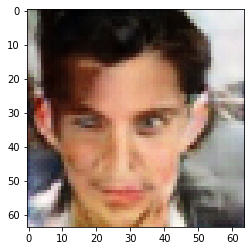

In [32]:
# Defining the Hyperparameters
z_dim = 100
lr_rate = 0.0002
beta1 = 0.5
alpha = 0.2
shape = 64,64,3

tf.reset_default_graph()

# Defining the Model
net = DCGAN(shape, z_dim, lr_rate, beta1, alpha)

sample(net, z_dim, model_dir, generated_images_dir)